In [114]:
import pandas as pd
import numpy as np
import sqlite3
pd.set_option('display.max_columns', None)
import matplotlib as plt
import plotly.express as px
from scipy import stats
import sqlite3

- **Store Analysis**:
    - Categorize the retail liquor stores into different types, chain-super market, specialized
    liquor stores, convenience stores, news stands, tobacco stores,..... and report the relevant statistics.
    - New stores pop up and some of them shut down after a few years. Analyze the store opening dynamics
    and report the findings on store life-cycle, store survival analysis, survial curve, survival
    probabilities, etc. Refine your findings based on the store categories you design. Is it easy for
    the stores to experience sales volume growth? With new stores popping up for competition, how does
    it affect the sales of the existing stores?  
    Does the pie (Gross sales volume in **Iowa**) grow bigger? Do the stores share the bigger pie?
    Does the winner take all or more players share smaller slices?
    - In terms of store inventories, report the varieties of product/product category for different
    store types. 
    What product/product category are the major sales contributors for different types of stores?
    - Study the monthly sales volumes and gross profits (without taking price-discounts into account)
    of the stores. 
    - Use the county population information, 
    say https://www.iowa-demographics.com/counties_by_population, to estimate the stores-per-capita in different
        counties. Use the chain-supermarket **Hy-Vee** as a case study, depict its store distribution
        in different counties of Iowa and the their liquor sales dynamics.
     

### Store Category statistics
- describe for each category
- histogram 


- stores look at store that has the most sales volume, sales, (in which county)
- histogram of sales volume monthly or quarterly
- histogram 

# Query Data from db

In [229]:
# query data frame with store and transaction info
conn = sqlite3.connect("data/liquor.db")
query = '''
SELECT Date, t."Store Number", Sale, "Volume Sold", County, "Store Type" 
FROM transactions AS t
LEFT JOIN stores AS s ON t."Store Number" = s."Store Number";

'''
store_df = pd.read_sql_query(query, conn)
conn.close()
store_df.head(3)

Date Store Number    Sale  Volume Sold      County  \
0  2012-05-03 00:00:00         2636  123.60         21.0        polk   
1  2012-07-05 00:00:00         3735   15.84          1.2    buchanan   
2  2012-03-06 00:00:00         4631  116.88          9.0  black hawk   

             Store Type  
0  Liquor Tobacco Store  
1  Liquor Tobacco Store  
2                 Other

In [230]:
# Make Date column datetime
store_df.loc[:,'Date']=pd.to_datetime(store_df.Date)

In [231]:
store_df.head()

Date Store Number    Sale  Volume Sold      County  \
0 2012-05-03         2636  123.60         21.0        polk   
1 2012-07-05         3735   15.84          1.2    buchanan   
2 2012-03-06         4631  116.88          9.0  black hawk   
3 2013-08-26         3162   80.28         10.5   muscatine   
4 2015-08-12         2513   22.48          1.5     johnson   

                     Store Type  
0          Liquor Tobacco Store  
1          Liquor Tobacco Store  
2                         Other  
3  Other Grocery or Convenience  
4                   Supermarket

In [232]:
# Combined the Categories to Other for final presentation
store_df['Store Type'] = store_df['Store Type'].replace(['Other', 'Other Grocery or Convenience', 'Casino'], 'T Other')

In [263]:
store_df.head()

Date Store Number    Sale  Volume Sold      County  \
0 2012-05-03         2636  123.60         21.0        polk   
1 2012-07-05         3735   15.84          1.2    buchanan   
2 2012-03-06         4631  116.88          9.0  black hawk   
3 2013-08-26         3162   80.28         10.5   muscatine   
4 2015-08-12         2513   22.48          1.5     johnson   

             Store Type  
0  Liquor Tobacco Store  
1  Liquor Tobacco Store  
2               T Other  
3               T Other  
4           Supermarket

### CSV for R
- to create combined bar and line graph for volume sale growth overall and by store type

In [296]:
import datetime
# Create df grouped by year summing volume sales
store_line_vol_y= store_df.groupby([pd.Grouper(key='Date', freq='Y')]).agg({'Volume Sold':'sum'}).reset_index()

# Create column Year
store_line_vol_y['Year'] = pd.DatetimeIndex(store_line_vol_y['Date']).year

# Convert Volume column to millions of dollars
store_line_vol_y['Volume Sold'] = store_line_vol_y['Volume Sold']/1000000

In [297]:
# Create df group by Y and Store type sum volume sold
store_bar_p_y = store_df.groupby([pd.Grouper(key='Date', freq='Y'),'Store Type']).agg({'Volume Sold':'sum'}).reset_index()

# Create column Percent for normalized store volumes sold
store_bar_p_y['Percent'] = store_bar_p_y.groupby([pd.Grouper(key='Date', freq='Y')]).transform(lambda x: (x/sum(x))*17.5)

# Create year column
store_bar_p_y['Year'] = pd.DatetimeIndex(store_bar_p_y['Date']).year

In [ ]:
# Merge dataframes
store_r = pd.merge(store_bar_p_y,store_line_vol_y,how='left', on= 'Year')

# Get rid of 2020 data
store_r = store_r.loc[store_r.Year!=2020]

In [300]:
store_r['Store Type'] = store_r['Store Type'].replace(['T Other'], 'Other')

In [301]:
# and write to csv for R
store_r.to_csv('data/store_r2.csv',index=False)

## EDA

##### Overall Sales and Volumn Sold

In [5]:
store_df.describe()

Sale   Volume Sold
count  1.944582e+07  1.944583e+07
mean   1.344986e+02  9.119876e+00
std    4.545768e+02  3.308114e+01
min    0.000000e+00  0.000000e+00
25%    3.150000e+01  1.500000e+00
50%    7.140000e+01  5.000000e+00
75%    1.387200e+02  1.050000e+01
max    2.795573e+05  1.500000e+04

##### Sale and Volume by Store Type

In [264]:
store_type_g = store_df.groupby('Store Type')
store_type_g.describe()


Sale                                             \
                          count        mean         std  min    25%    50%   
Store Type                                                                   
Convenience Store     2910468.0   90.233113  133.059830  0.0  28.98  64.00   
Drug Store            1168147.0  117.932000  316.143288  0.0  34.48  71.46   
Liquor Tobacco Store  5747389.0  121.280040  316.117998  0.0  24.76  64.02   
Supermarket           7433847.0  168.219996  636.991822  0.0  43.48  88.20   
T Other               2185970.0  122.365470  333.764144  0.0  28.50  64.80   

                                        Volume Sold                        \
                         75%        max       count       mean        std   
Store Type                                                                  
Convenience Store     117.00   28998.00   2910468.0   5.955589   8.739527   
Drug Store            132.24   34619.76   1168150.0   8.668350  29.783768   
Liquor Tobacco Store  132.78   69081.60   5747392.0   7.782613  23.023221   
Supermarket           160.56  279557.28   7433851.0  11.717237  46.167261   
T Other               127.44   51012.00   2185970.0   8.257276  21.808510   

                                                      
                       min   25%  50%   75%      max  
Store Type                                            
Convenience Store     0.02  1.50  4.5   9.0   2100.0  
Drug Store            0.00  1.80  6.0  10.5   2100.0  
Liquor Tobacco Store  0.00  1.50  3.5  10.5   6300.0  
Supermarket           0.00  2.25  9.0  10.5  15000.0  
T Other               0.02  1.50  4.5  10.5   2100.0

In [265]:
# Create grouped object that groups by Month
store_m_g = store_df.groupby([pd.Grouper(key='Date',freq='M')])


In [266]:
# histogram of overall monthly sales volume
fig = px.histogram(store_m_g.sum().reset_index(), 
                   x='Volume Sold', nbins=25, title='Overall Monthly sales Volume')
fig

In [267]:
# Create grouped object that groups by store type and Month
store_type_m_g = store_df.groupby(['Store Type', 
                              pd.Grouper(key='Date', 
                                         freq='M')])


In [81]:
# histogram of store monthly sales volume divided by store type
fig = px.histogram(store_type_m_g.sum().reset_index(), 
                   x='Volume Sold',
                   facet_col='Store Type',
                   facet_col_wrap=2)
fig


In [82]:
# look at the quarterly sales per store and get histogram
store_nu_q_g = store_df.groupby(['Store Number', pd.Grouper(key='Date',freq='Q')])

In [83]:
fig = px.histogram(store_nu_q_g.sum().reset_index(), 
                   x='Volume Sold', nbins=30, title='Monthly Volume Sold per Store')
fig

### Store Type that Buy/Sells most Volume

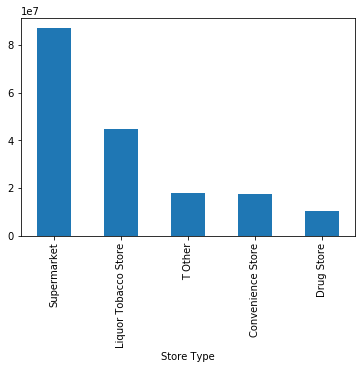

In [268]:
# Volume Sold by Store type 
# Supermarkets sell the most liquor
store_type_g['Volume Sold'].sum().sort_values(ascending=False).plot.bar()

In [269]:
# boxplots showing montly sales volume category may be better way to represent volume sales by store type
fig = px.box(store_type_m_g.sum().sort_values(by='Volume Sold',ascending=False).reset_index(), 
             x = 'Store Type',
             y ='Volume Sold',
             title='Total Monthly Sales Volume by Store Type')
fig

In [270]:
store_m_ty_no_g_ave=store_df.groupby(['Store Type', pd.Grouper(key='Date', freq='M'), 'Store Number']).sum().reset_index().groupby(['Store Type', pd.Grouper(key='Date', freq='M')]).mean().reset_index()

In [271]:
store_ave_map = {'Supermarket':1, 'Casino':6, 'Other':4, 'Drug Store':3, 'Liquor Tobacco Store':2, 'Other Grocery or Convenience':5, 'Convenience Store':7}

store_m_ty_no_g_ave['Order'] = store_m_ty_no_g_ave['Store Type'].map(store_ave_map)


In [272]:

fig = px.box(store_m_ty_no_g_ave.sort_values(by='Order'), 
             x = 'Store Type',
             y ='Volume Sold',
             title='Average Monthly Store Sales Volume')
fig.update_layout(yaxis_title="Volume Sold (Liters)",
                 title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

In [273]:
store_df.head()

Date Store Number    Sale  Volume Sold      County  \
0 2012-05-03         2636  123.60         21.0        polk   
1 2012-07-05         3735   15.84          1.2    buchanan   
2 2012-03-06         4631  116.88          9.0  black hawk   
3 2013-08-26         3162   80.28         10.5   muscatine   
4 2015-08-12         2513   22.48          1.5     johnson   

             Store Type  
0  Liquor Tobacco Store  
1  Liquor Tobacco Store  
2               T Other  
3               T Other  
4           Supermarket

In [274]:
tt_store_mean= store_type_m_g.mean().reset_index()

In [275]:
store_ave_map = {'Supermarket':1, 'Casino':2, 'Other':3, 'Drug Store':4, 'Liquor Tobacco Store':5, 'Other Grocery or Convenience':6, 'Convenience Store':7}

tt_store_mean["Order"] = tt_store_mean["Store Type"].map(store_ave_map) 

In [276]:
# Supermarket, Casino, Drug Store, Liquor, and Convenience Store 
# are significantly different from each other
px.box(tt_store_mean.sort_values(by='Order').reset_index(), 
             x = 'Store Type',
             y ='Volume Sold',
             title='Average Monthly Store Sales Volume by Store Type')

In [130]:
from scipy import stats


# Casino and Supermarket are significantly different 
# pvalue=0.02681811922044221
stats.ttest_ind(tt_store_mean.loc[tt_store_mean['Store Type']=='Casino']['Volume Sold'],tt_store_mean.loc[tt_store_mean['Store Type']=='Supermarket']['Volume Sold'])



Ttest_indResult(statistic=-2.230204041771995, pvalue=0.026818119220442214)

In [140]:
# Casino and Other are not significantly different
# pvalue=0.50463932688488054
stats.ttest_ind(tt_store_mean.loc[tt_store_mean['Store Type']=='Casino']['Volume Sold'],tt_store_mean.loc[tt_store_mean['Store Type']=='Other']['Volume Sold'])



Ttest_indResult(statistic=6.940208571538946, pvalue=5.0463932688488054e-11)

In [145]:
# Casino and Drug Store are significantly different
# pvalue=7.41395120593647e-17
stats.ttest_ind(tt_store_mean.loc[tt_store_mean['Store Type']=='Casino']['Volume Sold'],tt_store_mean.loc[tt_store_mean['Store Type']=='Drug Store']['Volume Sold'])



Ttest_indResult(statistic=9.113116456046054, pvalue=7.41395120593647e-17)

In [146]:
# Liquor and Drug Store are significantly different
# pvalue=3.888875737051862e-15
stats.ttest_ind(tt_store_mean.loc[tt_store_mean['Store Type']=='Drug Store']['Volume Sold'],tt_store_mean.loc[tt_store_mean['Store Type']=='Liquor Tobacco Store']['Volume Sold'])



Ttest_indResult(statistic=8.49754130648912, pvalue=3.888875737051862e-15)

In [129]:
tt_store_mean.loc[tt_store_mean['Store Type']=='Casino']['Volume Sold']

Store Type       Date        Sale  Volume Sold
0       Casino 2012-01-31  176.152742    10.145485
1       Casino 2012-02-29  169.517500    10.127016
2       Casino 2012-03-31  170.561042    10.393822
3       Casino 2012-04-30  169.738421     9.348684
4       Casino 2012-05-31  166.834240     9.290636
..         ...        ...         ...          ...
98      Casino 2020-03-31  271.549214    17.360714
99      Casino 2020-05-31  228.932500     5.600000
100     Casino 2020-06-30  140.393744     6.437436
101     Casino 2020-07-31  189.296679     7.404198
102     Casino 2020-08-31  238.237649    10.657090

[103 rows x 4 columns]

In [128]:
tt_store_mean

Store Type       Date        Sale  Volume Sold
0         Casino 2012-01-31  176.152742    10.145485
1         Casino 2012-02-29  169.517500    10.127016
2         Casino 2012-03-31  170.561042    10.393822
3         Casino 2012-04-30  169.738421     9.348684
4         Casino 2012-05-31  166.834240     9.290636
..           ...        ...         ...          ...
722  Supermarket 2020-04-30  195.201290    12.955931
723  Supermarket 2020-05-31  169.805159    11.935983
724  Supermarket 2020-06-30  185.536949    12.443286
725  Supermarket 2020-07-31  189.986161    12.710560
726  Supermarket 2020-08-31  195.355524    12.827051

[727 rows x 4 columns]

# Seasonality by store type based off of sales volume

In [277]:
# GROUP BY YEAR AND SEE TREND

In [278]:
px.line(store_df.groupby(['Store Type', pd.Grouper(key='Date', freq='Y')])[['Volume Sold']].sum().reset_index(),x='Date', y='Volume Sold', color = 'Store Type', title='Volume Sold by Month and Store Type')

In [279]:
fig = px.line(store_df.groupby(['Store Type', pd.Grouper(key='Date', freq='Q')])[['Volume Sold']].sum().reset_index(),x='Date', y='Volume Sold', color = 'Store Type',title='Total Quarterly Sales Volume')
fig.update_layout(yaxis_title="Volume Sold (Liters)",
                 title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

In [280]:
# Use groupby defined earlier
store_vol = store_type_m_g[['Volume Sold']].sum().reset_index()

# Pivot to get line graph
store_vol = store_vol.pivot(index = 'Date', 
                           columns = 'Store Type', 
                           values = 'Volume Sold').reset_index()

# Figure showing volume sold by store category over the months
# Takeaway: Seasonality shows up in all categories except Casino(too small). 
# Largest fluctuations seem to result from Grocery stores then Liquor and then Drug stores. 
# Convenience store sales might be on the rise
fig = px.line(store_vol, x='Date', y=store_vol.columns, title='Volume Sold by Month and Store Type')
fig

### Overall Volume Sales by month

In [92]:
fig = px.line(store_m_g.sum().reset_index(), 
              x='Date', 
              y='Volume Sold', 
              title='Total Volume Sold by Month')
fig
# Overall upward trend

## Store Life Cycle

New stores pop up and some of them shut down after a few years. Analyze the store opening dynamics and report the findings on store life-cycle, store survival analysis, survial curve, survival probabilities, etc. Refine your findings based on the store categories you design. Is it easy for the stores to experience sales volume growth? With new stores popping up for competition, how does it affect the sales of the existing stores?
Does the pie (Gross sales volume in Iowa) grow bigger? Do the stores share the bigger pie? Does the winner take all or more players share smaller slices



###  Overall Longevity

In [93]:
store_lon = store_df.groupby(['Store Number']).agg({'Date': 
                                        (lambda x: (max(x)-min(x)).days)}).sort_values(by='Date',
                                                                                ascending=False).reset_index()

In [94]:
store_lon.describe()

Date
count  2448.000000
mean   1733.835376
std    1154.605595
min       0.000000
25%     653.000000
50%    1596.500000
75%    3129.000000
max    3163.000000

In [95]:
fig = px.histogram(store_lon['Date'], nbins=30)
fig.update_layout(
    title='Store Longevity',
    xaxis_title="Number of Days Open",
    legend_title="",
    )
fig

### Store-type Longevity

In [96]:
store_t_lon = store_df.groupby(['Store Type', 
                                'Store Number']).agg({'Date':
                                                      (lambda x: 
                                                       (max(x)-min(x)).days)}).sort_values(by='Date',
                                                                                           ascending=False).reset_index()
store_t_lon.head(3)

Store Type Store Number  Date
0           Supermarket         4250  3163
1  Liquor Tobacco Store         2190  3163
2  Liquor Tobacco Store         2465  3163

In [97]:
fig = px.box(store_t_lon, 
             x = 'Store Type',
             y ='Date',
             title='Longevity by Store Type')
fig
# doesnt take into consideration stores that opened more recently

## Number of Stores over years

In [98]:
store_df.head()
# count number of unique stores each time period (m)

Date Store Number    Sale  Volume Sold      County  \
0 2012-05-03         2636  123.60         21.0        polk   
1 2012-07-05         3735   15.84          1.2    buchanan   
2 2012-03-06         4631  116.88          9.0  black hawk   
3 2013-08-26         3162   80.28         10.5   muscatine   
4 2015-08-12         2513   22.48          1.5     johnson   

                     Store Type  
0          Liquor Tobacco Store  
1          Liquor Tobacco Store  
2                         Other  
3  Other Grocery or Convenience  
4                   Supermarket

In [99]:
# overlay number of stores closed as well (no purchase for 6 months)
# think about the ratio of closure/open

In [100]:
fig = px.line(store_m_g.agg({'Store Number': pd.Series.nunique}).reset_index(), 
              x='Date', y='Store Number', title='Store Growth')
fig

In [281]:
# For some stores with long longevity how sales change over time

In [282]:
store_type_nu = store_type_m_g.agg({'Store Number': pd.Series.nunique}).reset_index().pivot(index= 'Date', columns = 'Store Type', values = 'Store Number').reset_index()

fig = px.line(store_type_nu, x='Date', y=store_type_nu.columns, title='Number of Stores by Store Type')
fig
# Number of convenience stores is growing rapidly

In [293]:

fig = px.line(store_type_q_g.agg({'Store Number': pd.Series.nunique}).reset_index(), x='Date', y='Store Number',color= 'Store Type', title='Store Number Growth')
fig.update_layout(yaxis_title="Number of Stores",
                 title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

In [284]:
store_type_q_g

In [254]:
store_type_q_g.sum()

Sale  Volume Sold
Store Type  Date                                 
Casino      2012-03-31  1.388853e+05      8237.00
            2012-06-30  1.291919e+05      7212.50
            2012-09-30  1.256997e+05      7033.45
            2012-12-31  1.591405e+05      8584.25
            2013-03-31  1.363054e+05      7663.50
...                              ...          ...
Supermarket 2019-09-30  4.057960e+07   2708410.89
            2019-12-31  4.960151e+07   3026334.38
            2020-03-31  3.867136e+07   2560534.79
            2020-06-30  4.757974e+07   3227221.19
            2020-09-30  3.105582e+07   2058744.88

[245 rows x 2 columns]

###  Divide volume by number stores in cat to get average? Vol sold by store. Over time is each store selling more or less

In [285]:
store_type_m_g_vol = store_type_m_g.agg({'Volume Sold': 'sum','Store Number': pd.Series.nunique}).reset_index()


In [286]:
store_type_m_g_vol['AveStoreSale'] = store_type_m_g_vol['Volume Sold']/store_type_m_g_vol['Store Number']

In [287]:
px.line(store_type_m_g_vol, x='Date', y='AveStoreSale', color='Store Type', title='Average Volume Sold per Store by Store Type')


## PLEASE USE G1

In [288]:
store_type_q_g = store_df.groupby(['Store Type', pd.Grouper(key='Date', freq='Q')])


In [289]:
store_type_q_g_vol = store_type_q_g.agg({'Volume Sold': 'sum','Store Number': pd.Series.nunique}).reset_index()


In [290]:
store_type_q_g_vol['AveStoreSale'] = store_type_q_g_vol['Volume Sold']/store_type_q_g_vol['Store Number']

In [295]:
fig =px.line(store_type_q_g_vol, x='Date', y='AveStoreSale', color='Store Type',title='Per Store Average Quarterly Sales Volume')
fig.update_layout(yaxis_title="Volume Sold (Liters)",
                 title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

# Some exploration of Vodka
- when have Xiaogang data - do some exploration of diff between two for price of vodka

- top 20 products and stacked barchart of types?

In [11]:
conn = sqlite3.connect("data/liquor.db")
query = '''
SELECT *
FROM transactions AS t
LEFT JOIN products AS p ON t."Item Number" = p."Item Number"
LIMIT(1)
'''
df = pd.read_sql_query(query, conn)
conn.close()
df.head(3)

Transaction ID Store Number Vendor Number Item Number  Bottles Sold  \
0   S05371200006         2636         421.0       36978            12   

   Volume Sold   Sale                 Date Item Number  category_id  \
0         21.0  123.6  2012-05-03 00:00:00       36978    1031080.0   

    category_name   product_name  bottle_vol_ml  proof category_new  imported  
0  vodka 80 proof  nikolai vodka         1750.0   80.0        vodka  domestic

In [12]:
conn = sqlite3.connect("data/liquor.db")
query = '''
SELECT Date, p.product_name, category_new, "Volume Sold", proof, Sale
FROM transactions AS t
LEFT JOIN products AS p ON t."Item Number" = p."Item Number"
'''
df = pd.read_sql_query(query, conn)
conn.close()
df.head(3)

Date           product_name category_new  Volume Sold  \
0  2012-05-03 00:00:00          nikolai vodka        vodka         21.0   
1  2012-07-05 00:00:00  kessler blend whiskey       whisky          1.2   
2  2012-03-06 00:00:00          uv cake vodka        vodka          9.0   

   proof    Sale  
0   80.0  123.60  
1   80.0   15.84  
2   60.0  116.88

In [13]:
df.loc[:,'Date']=pd.to_datetime(df.Date)

In [27]:
prod = df.loc[df.category_new=='vodka'].groupby([pd.Grouper(key='Date', freq='M'),'product_name']).agg({'Volume Sold':'sum', 'Sale':'sum', 'proof':'median'}).reset_index()


In [28]:
prod['PriceLiter'] = prod['Sale']/prod['Volume Sold']

In [29]:
prod.head()

Date                         product_name  Volume Sold     Sale  \
0 2012-01-31              360 concord grape vodka        15.75   335.37   
1 2012-01-31         360 concord grape vodka mini         5.50    83.05   
2 2012-01-31           360 double chocolate vodka        87.75  1868.49   
3 2012-01-31  360 double chocolate w/gravity unit        45.00   679.35   
4 2012-01-31              360 georgia peach vodka        42.75   910.29   

   proof  PriceLiter  
0   70.0   21.293333  
1    NaN   15.100000  
2   70.0   21.293333  
3    NaN   15.096667  
4   70.0   21.293333

In [30]:
prod.loc[prod['product_name']=='titos handmade vodka']

Date          product_name  Volume Sold        Sale  proof  \
239   2012-01-31  titos handmade vodka       764.50    13909.73   80.0   
534   2012-02-29  titos handmade vodka      1342.00    24882.74   80.0   
806   2012-03-31  titos handmade vodka      1084.25    20050.63   80.0   
1109  2012-04-30  titos handmade vodka      1309.50    24100.92   80.0   
1415  2012-05-31  titos handmade vodka      2293.75    42390.71   80.0   
...          ...                   ...          ...         ...    ...   
33783 2020-04-30  titos handmade vodka     93551.27  1664309.59   80.0   
34123 2020-05-31  titos handmade vodka    119943.22  2107864.57   80.0   
34472 2020-06-30  titos handmade vodka    124679.77  2268786.74   80.0   
34828 2020-07-31  titos handmade vodka     99254.95  1811974.34   80.0   
35172 2020-08-31  titos handmade vodka    148580.09  2600440.29   80.0   

       PriceLiter  
239     18.194545  
534     18.541535  
806     18.492626  
1109    18.404674  
1415    18.480963  
...           ...  
33783   17.790347  
34123   17.573853  
34472   18.196911  
34828   18.255758  
35172   17.501943  

[104 rows x 6 columns]

In [33]:
px.line(prod.loc[prod['product_name']=='hawkeye vodka'], x='Date', y= 'PriceLiter' )


In [36]:
px.line(prod.loc[prod['product_name']=='titos handmade vodka'], x='Date', y= 'PriceLiter' )

In [31]:
prod.loc[prod['product_name']=='hawkeye vodka']

Date   product_name  Volume Sold       Sale  proof  PriceLiter
88    2012-01-31  hawkeye vodka     72484.99  449395.92   80.0    6.199848
369   2012-02-29  hawkeye vodka     51258.71  320752.80   80.0    6.257528
650   2012-03-31  hawkeye vodka     77966.33  484178.69   80.0    6.210100
938   2012-04-30  hawkeye vodka     55102.69  344387.10   80.0    6.249914
1242  2012-05-31  hawkeye vodka     88649.82  552742.53   80.0    6.235123
...          ...            ...          ...        ...    ...         ...
33591 2020-04-30  hawkeye vodka     56696.53  363819.73   80.0    6.416966
33926 2020-05-31  hawkeye vodka     83074.54  530673.93   80.0    6.387925
34270 2020-06-30  hawkeye vodka     65759.23  421983.47   80.0    6.417099
34623 2020-07-31  hawkeye vodka     61836.42  397061.62   80.0    6.421161
34980 2020-08-31  hawkeye vodka     76924.98  490787.17   80.0    6.380075

[104 rows x 6 columns]

In [57]:
topvod=prod.groupby('product_name').agg({'Volume Sold':'sum'}).sort_values(by='Volume Sold',ascending=False).reset_index().head(20)


In [58]:
topvodlist = topvod.product_name.tolist()

In [59]:
px.line(prod.loc[prod['product_name'].isin(topvodlist)], x='Date', y='PriceLiter', color = 'product_name')

In [63]:
prod.loc[prod['product_name'].isin(topvodlist)].describe()

Volume Sold          Sale        proof   PriceLiter
count    2066.000000  2.066000e+03  2066.000000  2066.000000
mean    19043.410499  1.955500e+05    78.693127    11.192058
std     19154.032109  2.264100e+05     4.630222     6.853337
min       705.000000  9.729000e+03    60.000000     5.571429
25%      7873.935000  6.950135e+04    80.000000     6.380340
50%     12525.730000  1.336950e+05    80.000000     8.077789
75%     21990.612500  2.343825e+05    80.000000    13.274789
max    148580.090000  2.600440e+06    80.000000    36.655262

In [95]:
# need to get rid of some zeros in volume sold for all vodkas
prod.loc[prod['Volume Sold']!=0].describe()

Volume Sold          Sale         proof    PriceLiter
count   35203.000000  3.520300e+04  32929.000000  35203.000000
mean     1558.200554  1.789319e+04     73.403262     23.226187
std      6478.615063  7.190905e+04      7.628678     46.577756
min         0.050000  0.000000e+00     30.000000      0.000000
25%        42.250000  8.100000e+02     70.000000     13.000000
50%       144.000000  2.389340e+03     70.000000     16.506667
75%       490.625000  7.951325e+03     80.000000     22.346667
max    148580.090000  2.600440e+06    151.000000   3427.200000

In [96]:

from scipy import stats


# Top 20 PriceLiter is significantly different from rest of vodka
stats.ttest_ind(prod.loc[prod['Volume Sold']!=0]['PriceLiter'],prod.loc[prod['product_name'].isin(topvodlist)]['PriceLiter'])

In [112]:
# Top 20 proof is significantly different from rest of vodka
stats.ttest_ind(prod.loc[~np.isnan(prod.proof)]['proof'],prod.loc[(prod['product_name'].isin(topvodlist))&(~np.isnan(prod.proof))]['proof'])



Ttest_indResult(statistic=-31.1627982807702, pvalue=2.5739064160637365e-210)